In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 載入資料
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

# 先將兩份資料合併 (處理完再拆開)
all_data = pd.concat([train_df, test_df], sort=False)

In [2]:
# A. 提取稱謂 (Title)
all_data['Title'] = all_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 將稀有稱謂歸類
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

# B. 根據稱謂填補年齡 (更準確！)
all_data['Age'] = all_data.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# C. 家庭規模 (FamilySize)
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
all_data['IsAlone'] = 0
all_data.loc[all_data['FamilySize'] == 1, 'IsAlone'] = 1

# D. 填補其他缺失值
all_data['Embarked'] = all_data['Embarked'].fillna(all_data['Embarked'].mode()[0])
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].median())

# E. 轉換類別變數
all_data['Sex'] = all_data['Sex'].map({'male': 0, 'female': 1})
all_data = pd.get_dummies(all_data, columns=['Title', 'Embarked'], prefix=['Title', 'Emb'])

# F. 移除暫時不需要的欄位
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin']
all_data = all_data.drop(drop_elements, axis=1)

# G. 把資料拆回訓練集與測試集
train_cleaned = all_data[:len(train_df)]
test_cleaned = all_data[len(train_df):].drop('Survived', axis=1)

print("進階預處理完成")
display(train_cleaned.head())

進階預處理完成


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Emb_C,Emb_Q,Emb_S
0,0.0,3,0,22.0,1,0,7.2500,2,0,False,False,True,False,False,False,False,True
1,1.0,1,1,38.0,1,0,71.2833,2,0,False,False,False,True,False,True,False,False
2,1.0,3,1,26.0,0,0,7.9250,1,1,False,True,False,False,False,False,False,True
3,1.0,1,1,35.0,1,0,53.1000,2,0,False,False,False,True,False,False,False,True
4,0.0,3,0,35.0,0,0,8.0500,1,1,False,False,True,False,False,False,False,True


In [3]:
# 1. 準備訓練數據
X_advanced = train_cleaned.drop('Survived', axis=1)
y_advanced = train_cleaned['Survived']

# 切分資料 (驗證模型用)
X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split(X_advanced, y_advanced, test_size=0.2, random_state=42)

# 2. 定義 XGBoost 模型
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# 3. 定義想要搜尋的「參數格子」 (Grid)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# 4. 開始自動搜尋 (這可能需要幾秒鐘)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_adv, y_train_adv)

# 5. 輸出結果
print(f"最佳參數組合: {grid_search.best_params_}")
print(f"交叉驗證的最佳分數: {grid_search.best_score_:.4f}")

# 使用最強的模型在驗證集上試試看
best_model = grid_search.best_estimator_
y_pred_adv = best_model.predict(X_val_adv)
print(f"\n進階模型驗證集準確率: {accuracy_score(y_val_adv, y_pred_adv):.4f}")

最佳參數組合: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
交叉驗證的最佳分數: 0.8370

進階模型驗證集準確率: 0.8045


c:\Users\TMP-214\Documents\titanic-survival-analysis\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:44:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [4]:
# 1. 使用最佳模型對進階處理後的測試集進行預測
advanced_predictions = best_model.predict(test_cleaned)

# 2. 格式化為 submission 格式
submission_advanced = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": advanced_predictions
})

# 3. 輸出新的 CSV 檔案
submission_advanced.to_csv('submission_advanced.csv', index=False)

print("🎉 進階版預測完成！已生成 submission_advanced.csv")
display(submission_advanced.head())

🎉 進階版預測完成！已生成 submission_advanced.csv


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [5]:
from sklearn.metrics import f1_score, roc_auc_score

# 1. 計算 F1-score (綜合考慮精確率與召回率)
# 我們拿剛才預測出的 y_pred_adv 跟正確答案 y_val_adv 來比對
f1_adv = f1_score(y_val_adv, y_pred_adv)

# 2. 計算 ROC-AUC (衡量模型區分生存/死亡的分類能力)
# 注意：ROC-AUC 需要的是「機率」而非直接的 0 或 1
# 我們取預測為「1」(生存) 的那一欄機率
y_probs_adv = best_model.predict_proba(X_val_adv)[:, 1]
roc_auc_adv = roc_auc_score(y_val_adv, y_probs_adv)

print(f"--- XGBoost 進階模型評估 ---")
print(f"F1-score: {f1_adv:.4f}")
print(f"ROC-AUC : {roc_auc_adv:.4f}")

--- XGBoost 進階模型評估 ---
F1-score: 0.7518
ROC-AUC : 0.8954


C:\Users\TMP-214\AppData\Local\Temp\ipykernel_17644\2148423245.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[:10].values, y=importances[:10].index, palette='viridis', ax=ax[2])


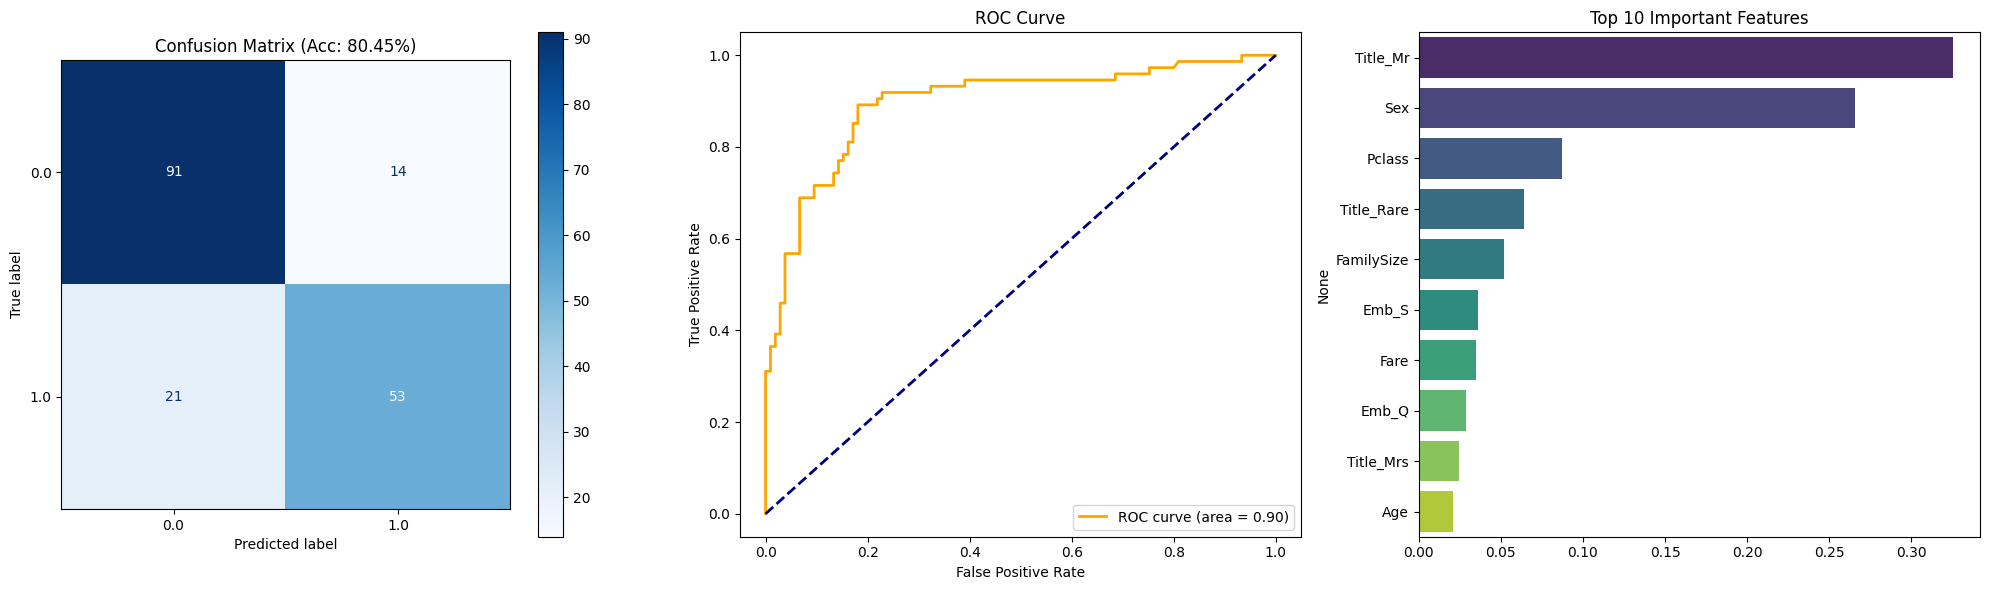

💡 分析指南：
1. 混淆矩陣：左上與右下數字越高越好。
2. ROC 曲線：曲線下方的面積 (Area) 越高，代表模型越有『區分生死』的能力。
3. 特徵重要性：觀察 'Title_Mr' 是不是最重要的？這通常代表它對生死的決定力最強。


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# 設定畫布大小，我們要放三張圖
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# --- 圖 1: 混淆矩陣 (Confusion Matrix) ---
# 讓你一眼看出模型是「死人救不活」還是「活人沒救到」
ConfusionMatrixDisplay.from_estimator(best_model, X_val_adv, y_val_adv, 
                                       cmap='Blues', ax=ax[0])
ax[0].set_title(f'Confusion Matrix (Acc: {accuracy_score(y_val_adv, y_pred_adv):.2%})')

# --- 圖 2: ROC 曲線 ---
# 曲線越靠近左上角，代表模型的「分辨力」越強
fpr, tpr, _ = roc_curve(y_val_adv, y_probs_adv)
ax[1].plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc_adv:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")

# --- 圖 3: 特徵重要性 (Feature Importance) ---
# 看看 XGBoost 到底是在看哪些特徵做決定的
importances = pd.Series(best_model.feature_importances_, index=X_advanced.columns).sort_values(ascending=False)
sns.barplot(x=importances[:10].values, y=importances[:10].index, palette='viridis', ax=ax[2])
ax[2].set_title('Top 10 Important Features')

plt.tight_layout()
plt.show()

# 補充說明
print(f"💡 分析指南：")
print(f"1. 混淆矩陣：左上與右下數字越高越好。")
print(f"2. ROC 曲線：曲線下方的面積 (Area) 越高，代表模型越有『區分生死』的能力。")
print(f"3. 特徵重要性：觀察 '{importances.index[0]}' 是不是最重要的？這通常代表它對生死的決定力最強。")